### Exercício 01

(a) Crie uma função (em Python) que seja capaz de reduzir e/ou aumentar a resolução
espacial de uma imagem por um fator n, que é um número real positivo (n>1 para um
aumento da resolução espacial e n< 1 para uma redução da resolução espacial). Tal
função deve possuir como parâmetros de entrada, o nome do arquivo da imagem para
leitua no disco e o fator n. Para aumento da resolução utilize a técnica do **vizinho-mais-próximo** vista em sala de aula.

In [2]:
import numpy as np
import cv2
from cv2 import imread
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
img_folder = 'imagens/'

In [4]:
def show_img(imgs, titles):
    width = 4 * len(imgs)
    height = 4
    plt.figure(figsize=(width, height))

    for i, (img, title) in enumerate(zip(imgs, titles)):
        img = img[:, :, ::-1]

        plt.subplot(1, len(imgs), i+1)
        plt.imshow(img)
        plt.title(title)
        plt.axis(False)

    plt.show()

In [7]:
def interpolate_neighbors_loop(size_new, row_positions, col_positions, img):
    img_resized = np.empty((size_new[0], size_new[1], 3), dtype=np.uint8)

    for i in range(len(row_positions)):
        for j in range(len(col_positions)):
            img_resized[i][j] = img[row_positions[i]][col_positions[j]]

    return img_resized

In [8]:
def interpolate_neighbors_vectorized(row_positions, col_positions, img):
    return img[row_positions, :][:, col_positions]

In [9]:
def interpolate_neighbors(img, size_new, fator, method='vectorized'):
    row_positions = (np.ceil((np.arange(size_new[0]) + 1) / fator) - 1).astype(int)
    col_positions = (np.ceil((np.arange(size_new[1]) + 1) / fator) - 1).astype(int)

    if method == 'vectorized':
        return interpolate_neighbors_vectorized(row_positions, col_positions, img)
    elif method == 'loop':
        return interpolate_neighbors_loop(size_new, row_positions, col_positions, img)
    else:
        print('Método não disponível')
        return

In [10]:
def mudanca_resolucao(img, fator, method='vizinho'):
    size_original = np.array(img.shape[:2])
    size_new = (size_original * fator).astype(int)

    img_resized = None

    if method == 'vizinho':
        img_resized = interpolate_neighbors(img, size_new, fator)
    elif method == 'bilinear':
        img_resized = interpolate_bilinear(img, size_new, fator)
    else:
        print('Método não disponível')
        pass

    return img_resized

In [11]:
def mudanca_resolucao_path(img_path, fator, method='vizinho'):
    img = imread(img_path)

    return mudanca_resolucao(img, fator, method)

(b) Utilize o sua função do item anterior para gerar imagens com resolução espacial
**reduzida** por fatores de 2, 4, 8 e 16. Em seguida, utilize o seu programa novamente para
aumentar estas imagens de volta ao seu tamanho original. Há diferenças de qualidade
entre estas imagens? Comente. (Obs.: Plote os resultados para que possam se
visualizados).

In [12]:
fatores = [2, 4, 8, 16]
img_path = img_folder + 'lenna.png'

Tamanho original da imagem (512, 512)


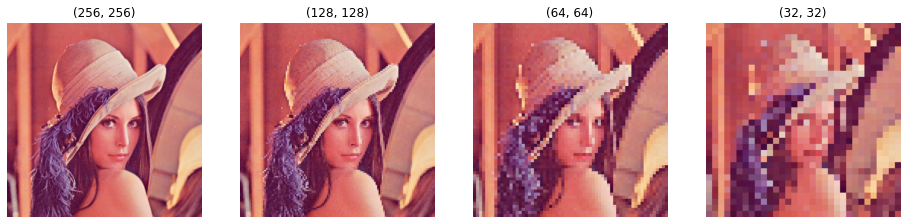

In [13]:
img_reduzidas = []
img_aumentadas = []
titulos = []

print(f'Tamanho original da imagem {imread(img_path).shape[:2]}')

for fator in fatores:
    fator = 1/fator
    img_reduzidas.append(mudanca_resolucao_path(img_path, fator, 'vizinho'))

for fator, img in zip(fatores, img_reduzidas):
    img_aumentadas.append(mudanca_resolucao(img, fator, 'vizinho'))
    titulos.append(f'{img.shape[:2]}')

show_img(img_aumentadas, titulos)


(c) Modifique a função desenvolvida em (a), de forma que seja utilizada a técnica de
**interpolação bilinear** e refaça o que se pede no item (b) novamente. (Obs.: Plote os
resultados para que possam se visualizados).

In [14]:
def interpolate_bilinear(img, size_new, fator):
    img_resized = np.empty((size_new[0], size_new[1], 3), dtype=np.uint8)

    for row in range(size_new[0]):
        for col in range(size_new[1]):
            x_new = (1/fator) * col
            y_new = (1/fator) * row

            x1 = np.floor(x_new).astype(int)
            y1 = np.floor(y_new).astype(int)
            x2 = np.ceil(x_new).astype(int)
            y2 = np.ceil(y_new).astype(int)

            #limite final das posições da imagem
            if x2 == img.shape[:2][0]:
                x2 -= 1
            if y2 == img.shape[:2][1]:
                y2 -= 1

            dx = x_new - x1
            dy = y_new - y1

            A = img[y1][x1]
            B = img[y1][x2]
            C = img[y2][x1]
            D = img[y2][x2]

            px1 = (1 - dx) * (1 - dy) * A
            px2 = dx * (1 - dy) * B
            px3 = (1 - dx) * dy * C
            px4 = dx * dy * D

            img_resized[row][col] = px1 + px2 + px3 + px4

    return img_resized

Tamanho original da imagem (512, 512)


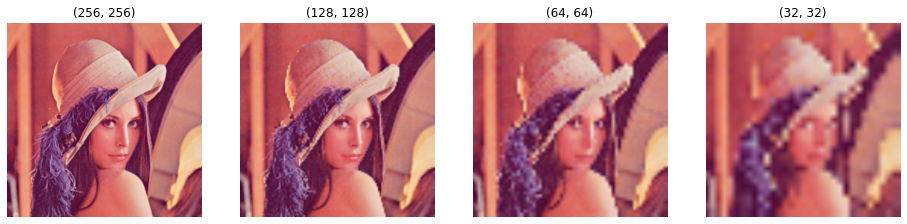

In [16]:
img_reduzidas = []
img_aumentadas = []
titulos = []

print(f'Tamanho original da imagem {imread(img_path).shape[:2]}')

for fator in fatores:
    fator = 1/fator
    img_reduzidas.append(mudanca_resolucao_path(img_path, fator, 'bilinear'))

for fator, img in zip(fatores, img_reduzidas):
    img_aumentadas.append(mudanca_resolucao(img, fator, 'bilinear'))
    titulos.append(f'{img.shape[:2]}')

show_img(img_aumentadas, titulos)

### Exercício 02

(a) Escreva uma função que realize a filtragem espacial de uma imagem. Essa função
terá 2 parâmetros de entrada: a imagem a ser transformada e o filtro a ser utilizado.

In [5]:
def img_padding(img, filter_shape):
    padding = filter_shape[0] - 1
    start = int((filter_shape[0] - 1)/2)
    end = -start

    img_padded = np.zeros(np.array(img.shape) + [padding, padding, 0], dtype=np.uint8)
    img_padded[start:end, start:end, :] = img

    return img_padded

In [6]:
def filtra_espacial(img_path, filtro, average_filter=False):
    img = imread(img_path)
    rows = img.shape[0]
    cols = img.shape[1]
    colors = img.shape[2]

    filter_shape = filtro.shape
    filtro = filtro[:, :, None] * np.ones(colors, dtype=int)[None, None, :]

    img_padded = img_padding(img, filter_shape)
    img_filtered = np.empty(img.shape)

    for y in range(rows):
        for x in range(cols):

            ### Remover as bordas pretas dos filtros grandes
            y_diff = y - filter_shape[0]//2
            x_diff = x - filter_shape[1]//2

            if y_diff <= 0:
                y_start = filter_shape[0]//2 + 1
            else:
                y_start = y

            y_end = y + filter_shape[0]
            y_end = min(y_end, rows)

            if x_diff <= 0:
                x_start = filter_shape[1]//2 + 1
            else:
                x_start = x

            x_end = x + filter_shape[1]
            x_end = min(x_end, cols)

            part = img_padded[y_start:y_end, x_start:x_end]

            y_filter_diff = y_end - y_start
            x_filter_diff = x_end - x_start

            if average_filter:
                filter_norm = y_filter_diff * x_filter_diff 
            else:
                filter_norm = 1

            filtered = np.sum(part * filtro[:y_filter_diff, :x_filter_diff, :] / filter_norm, axis=(0, 1))

            img_filtered[y, x] = filtered
    
    ### Remover valores extremos
    img_filtered = img_filtered.clip(min=0, max=255).astype('uint8')

    return img_filtered

(b) Aplique os filtros abaixo na imagem da Lena (que foi enviada com o trabalho).
Compare os resultados obtidos para cada um dos filtros. Com base nestes resultados,
qual o tipo de filtro (passa-alta, passa-baixa, passa-faixa, etc.) que está sendo utilizado
em cada caso e qual o efeito de cada filtro na imagem.

In [9]:
img_path = img_folder + 'lenna.png'
img_original = imread(img_path)

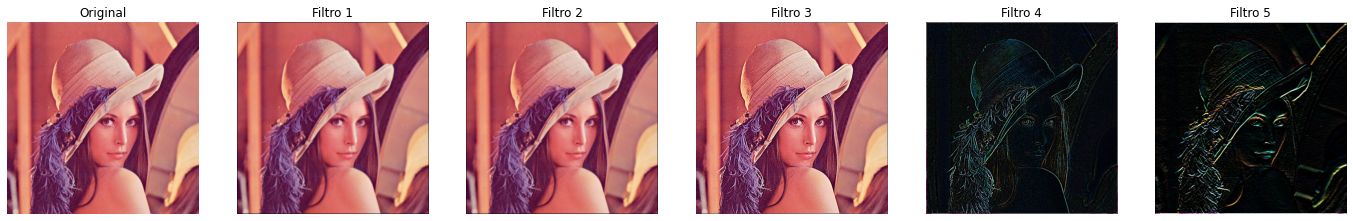

In [8]:
filtro1 = 1/9 * np.array([
    [1, 1, 1],
    [1, 1, 1],
    [1, 1, 1]])

filtro2 = 1/16 * np.array([
    [1, 2, 1],
    [2, 4, 2],
    [1, 2, 1]])

filtro3 = np.array([
    [ 0, -1,  0],
    [-1,  5, -1],
    [ 0, -1,  0]])

filtro4 = np.array([
    [-1, -1, -1],
    [-1,  8, -1],
    [-1, -1, -1]])

filtro5 = np.array([
    [ 1,  2,  1],
    [ 0,  0,  0],
    [-1, -2, -1]])

filtros = [filtro1, filtro2, filtro3, filtro4, filtro5]

imgs = [img_original]
for filtro in filtros:
    imgs.append(filtra_espacial(img_path, filtro))

titles = ['Original', 'Filtro 1', 'Filtro 2', 'Filtro 3', 'Filtro 4', 'Filtro 5']
show_img(imgs, titles)

**Análise**

Os filtros 1 e 2 são filtros passa-baixa, que possuem a função de borrar (suavizar) mais a imagem. O filtro 2 (gaussiano) dá mais importância ao valor dos pixels mais centrais sendo analisados a cada passagem do filtro, fazendo com que exista uma menor variação do valor original do pixel. Já o filtro 1 (média) dá a mesma importância para todos os pixels.

Os filtros 3, 4 e 5 são filtros passa-alta, que possuem a função de realçar mais os detalhes das imagens, enfatizando o contorno das linhas. O filtro 3 realça as linhas em todas as direções sem perder as cores da imagem, já o filtro 4 (laplaciano) detecta as bordas em todas as direções só que com perda das cores da imagem. O filtro 5 é um filtro de Sobel que enfatiza as linhas horizontais da imagem original.

(c) O filtro 1 possui tamanho 3x3. O que aconteceria se aumentássemos o tamanho do
filtro para 11x11, 17x17 ou 35x35? De que forma o tamanho do filtro afeta a imagem?

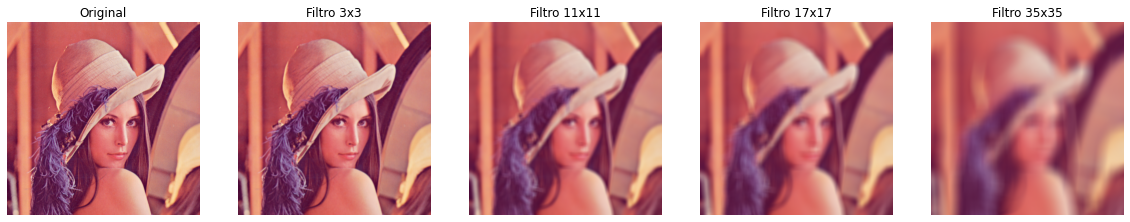

In [10]:
filtro3x3 = np.ones((3,3))
filtro11x11 = np.ones((11,11))
filtro17x17 = np.ones((17,17))
filtro35x35 = np.ones((35,35))

filtros = [filtro3x3, filtro11x11, filtro17x17, filtro35x35]

imgs = [img_original]
for filtro in filtros:
    imgs.append(filtra_espacial(img_path, filtro, average_filter=True))

titles = ['Original', 'Filtro 3x3', 'Filtro 11x11', 'Filtro 17x17', 'Filtro 35x35']
show_img(imgs, titles)

**Análise**

Quanto maior o tamanho do filtro, mais a imagem vai ficando borrada, visto que o tamanho do filtro vai se aproximando às dimensões da imagem sendo filtrada, fazendo com que os cálculos de médias acabem utilizando uma quantidade muito maior de pixels em cada iteração do processo de correlação.

### Exercício 03

(a)Converta os filtros h1 e h2 para o domínio da frequência. Visualize o **módulo** de cada
filtro. Obs: Para visualizar melhor a resposta do filtro no domínio da frequência **desloque
a frequência (0,0) para o centro da imagem.**

(b) Filtre, no domínio da frequência, três imagens (diferentes e de sua escolha) com cada
um dos dois filtros. Em seguida, calcule a transformada inversa. O resultado da **filtragem
espacial** (use a função implementada na segunda questão para verificar o resultado da
filtragem espacial) é o mesmo da **filtragem no domínio da frequência**? Justifique.

### Exercício 04

(a) Tire a transformada das imagens **noiseball.png** e **footBallOrig.png** (enviadas juntas
com a atividade). Visualize o módulo (ou magnitude) destas transformadas. Há alguma
diferença? É possível recuperar a imagem **noiseball.png** e eliminar o ruído? Justifique
sua resposta.

(b) Calcule a transformada inversa da imagem filtrada e visualize o resultado. Comente.